In [31]:
from __future__ import annotations as _annotations

from website_to_rag.utils.webpage_extractor import WebPage, Section

from typing import Set
from dataclasses import dataclass, field

from pydantic_graph import BaseNode, GraphRunContext, End, Graph
from pydantic_ai import Agent, RunContext
from pydantic_ai.messages import ModelMessage
from pydantic_ai.models.openai import OpenAIModel
from rich.prompt import Prompt

from openai import AsyncOpenAI
import ollama

from typing import Protocol


In [32]:
class Embedder(Protocol):
    def __call__(self, text: str) -> list[float]:
        ...

In [48]:
class OllamaEmbedder:
    def __init__(self, model_name: str):
        self.model_name = model_name

    def __call__(self, text: str) -> list[float]:
        return ollama.embeddings(prompt=text, model=self.model_name).embedding

In [49]:
K = 8

In [90]:
@dataclass
class State:
    user_query: str
    retrieval_agent_history: list[ModelMessage] = field(default_factory=set)
    unused_urls: Set[str] = field(default_factory=set)
    searched_urls: Set[str] = field(default_factory=set)
    unembedded_webpages: list[WebPage] = field(default_factory=list)
    embedded_webpages: list[tuple(WebPage, Section, list[list[float]])] = field(
        default_factory=list
    )


@dataclass
class Ask(BaseNode[State]):
    """User asks a question"""
    async def run(self, ctx: GraphRunContext[State]) -> Plan:
        ctx.state.user_query = Prompt.ask("What can I help you with?")
        return Retrieval


@dataclass
class Plan(BaseNode[State]):
    """Plan the steps to answer the user's question"""
    def run(self, ctx: GraphRunContext[State]) -> Retrieval|Evaluate: ...

@dataclass
class RetrievalResult:
    top_5_results: list[str]
    urls: list[str]


@dataclass
class NoRelevantData: ...


@dataclass
class RetrievalDeps:
    embedded_webpages: list[tuple(WebPage, Section, list[list[float]])]
    embedding_model: Embedder


def create_retrieval_agent(model: str|OpenAIModel) -> Agent:
    #ollama_model = OpenAIModel(model_name='qwen2.5:7b', base_url='http://localhost:11434/v1')
    retrieval_agent = Agent[RetrievalDeps, RetrievalResult | NoRelevantData](
        model,
        result_type=RetrievalResult | NoRelevantData,
        deps_type=RetrievalDeps,
        system_prompt=(
            "Given a user query use the `retrieval_tool` to search websites in memory for information relevant to answer the user's question. "
            "If the information recieved is not relevant to the user's query try changing the prompt you give to the retrieval tool. "
            "If there still doesn't appear to be relevant information after 2 tries return 'NoRelevantData'"
        ),
        retries=2,
    )

    @retrieval_agent.tool(retries=2)
    async def retrieval_tool(ctx: RunContext[RetrievalDeps], prompt: str) -> list[dict[str, str]]:

        query_embedding = (ctx.deps.embedding_model(prompt))

        def _metric(webpage, section, embedding)->float:
            return section.compute_distance(query_embedding)

        top_k_results = sorted(
            ctx.deps.embedded_webpages, 
            key = lambda x: _metric(*x),
            reverse=True)[:K]
        
        return top_k_results
        
        
        

    return retrieval_agent


@dataclass
class Retrieval(BaseNode[State]):
    """Attempt to find information related to the question"""
    retrieval_tries: int = 0

    def run(self, ctx: GraphRunContext[State]) -> Search | Plan: 
        if self.retrieval_tries>2:
            self.retrieval_tries = 0
            return Search()


@dataclass
class Search(BaseNode[State]):
    """Search for more information if necessary"""
    def run(self, ctx: GraphRunContext[State]) -> EmbedWebPages: ...


@dataclass
class EmbedWebPages(BaseNode[State]):
    """Embed new information"""
    def run(self, ctx: GraphRunContext[State]) -> Retrieval: ...


@dataclass
class SummaryResult:
    summary: str
    sources: list[str]


@dataclass
class Evaluate(BaseNode[State]):
    """Evaluate model answer"""
    def run(self, ctx: GraphRunContext[State]) -> Plan|Summerize: ...


@dataclass
class Summerize(BaseNode[State, None, SummaryResult]):
    """Summerize the answer"""
    def run(self, ctx: GraphRunContext[State]) -> Evaluate|End[SummaryResult]: ...

In [91]:
graph = Graph(
    nodes=[Ask, Plan, Retrieval, Search, EmbedWebPages, Evaluate, Summerize],
    state_type=State,
    run_end_type=SummaryResult
)

In [92]:
from IPython.display import display, Image, Markdown

INFO:httpx:HTTP Request: GET https://mermaid.ink/img/LS0tCnRpdGxlOiBncmFwaAotLS0Kc3RhdGVEaWFncmFtLXYyCiAgWypdIC0tPiBBc2sKICBBc2sgLS0+IFBsYW4KICBQbGFuIC0tPiBSZXRyaWV2YWwKICBQbGFuIC0tPiBFdmFsdWF0ZQogIFJldHJpZXZhbCAtLT4gU2VhcmNoCiAgUmV0cmlldmFsIC0tPiBQbGFuCiAgU2VhcmNoIC0tPiBFbWJlZFdlYlBhZ2VzCiAgRW1iZWRXZWJQYWdlcyAtLT4gUmV0cmlldmFsCiAgRXZhbHVhdGUgLS0+IFBsYW4KICBFdmFsdWF0ZSAtLT4gU3VtbWVyaXplCiAgU3VtbWVyaXplIC0tPiBFdmFsdWF0ZQogIFN1bW1lcml6ZSAtLT4gWypd "HTTP/1.1 200 OK"


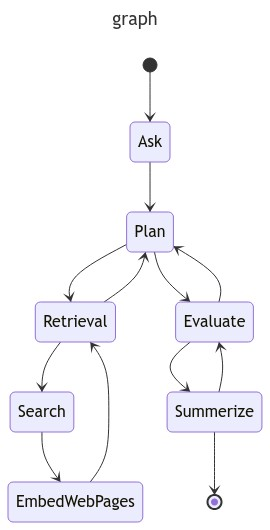

In [93]:
Image(graph.mermaid_image(start_node=Ask))

In [94]:
agent = create_retrieval_agent(OpenAIModel(model_name='qwen2.5:7b', base_url='http://localhost:11434/v1'))

In [95]:
result = agent.run('Where were the olympics held in 2012?', deps=RetrievalDeps(embedded_webpages=[], embedding_model=OllamaEmbedder('nomic-embed-text')))

In [96]:
data = await result

INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


In [97]:
data.data

NoRelevantData()

In [30]:
response = ollama.embeddings(model='nomic-embed-text', prompt='The sky is blue because of rayleigh scattering')

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embeddings "HTTP/1.1 200 OK"


In [29]:
response

EmbeddingsResponse(embedding=[0.5889952182769775, 0.400834858417511, -3.303218126296997, -0.525968074798584, 0.7489901781082153, 1.5185997486114502, -0.1251041144132614, 0.39591342210769653, 0.06778016686439514, -1.1088330745697021, 0.6926167011260986, 1.2775923013687134, 1.146063208580017, 1.089024543762207, 0.2504419982433319, 0.2928600311279297, 0.1518256962299347, -0.6344521045684814, -0.2100622057914734, -0.1958126723766327, -1.7958611249923706, -0.6291590332984924, 0.03886444866657257, -0.6687489748001099, 1.26125967502594, 1.2771027088165283, -0.15987950563430786, -0.0024411454796791077, -0.29727184772491455, -0.4807409644126892, 1.2050529718399048, -0.6383835077285767, -0.5400329828262329, -1.0354485511779785, 0.6314492225646973, -1.208990454673767, 0.6834062337875366, -0.058553166687488556, -0.19721460342407227, 0.12762127816677094, -0.014400124549865723, -0.5544140934944153, 0.3516940772533417, 0.04494372010231018, 0.597441554069519, -0.9552484154701233, 0.5079353451728821, 1

/Users/redam94/Coding/Projects/website_to_rag/.venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


            ready to drink protein shakes  isPartial
date                                                
2020-01-26                             58      False
2020-02-02                              0      False
2020-02-09                             66      False
2020-02-16                              0      False
2020-02-23                             63      False


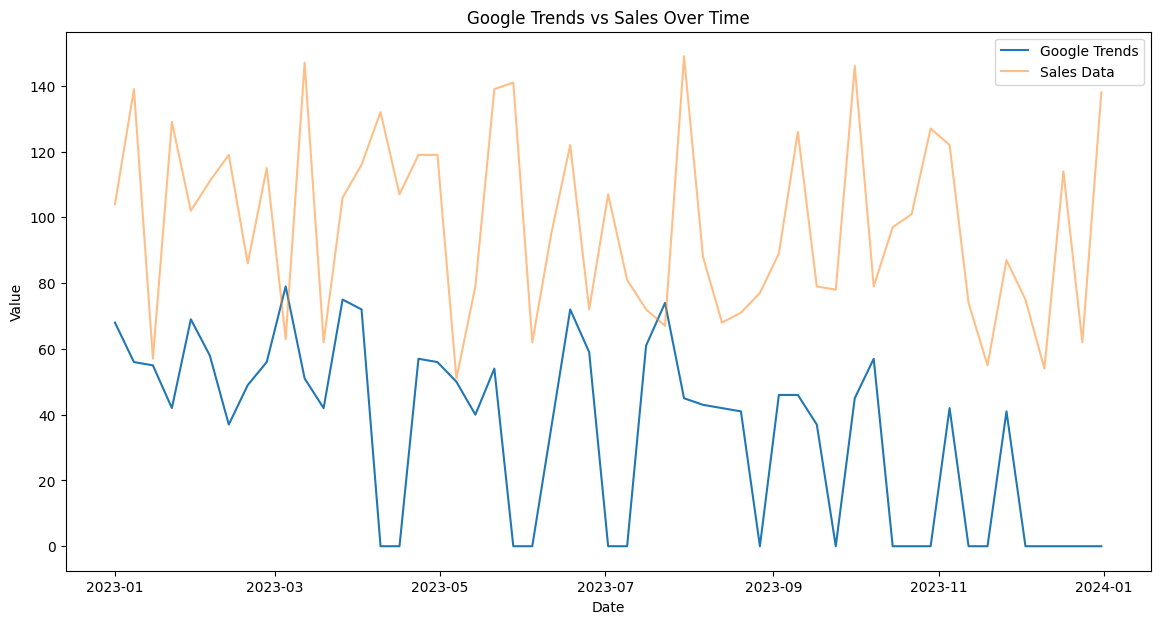

Mean Squared Error: 442.9121953130478
Cross-Validation Mean Squared Error: 941.3215535549036
Coefficients: [0.11424315]
Intercept: 91.9279767376156


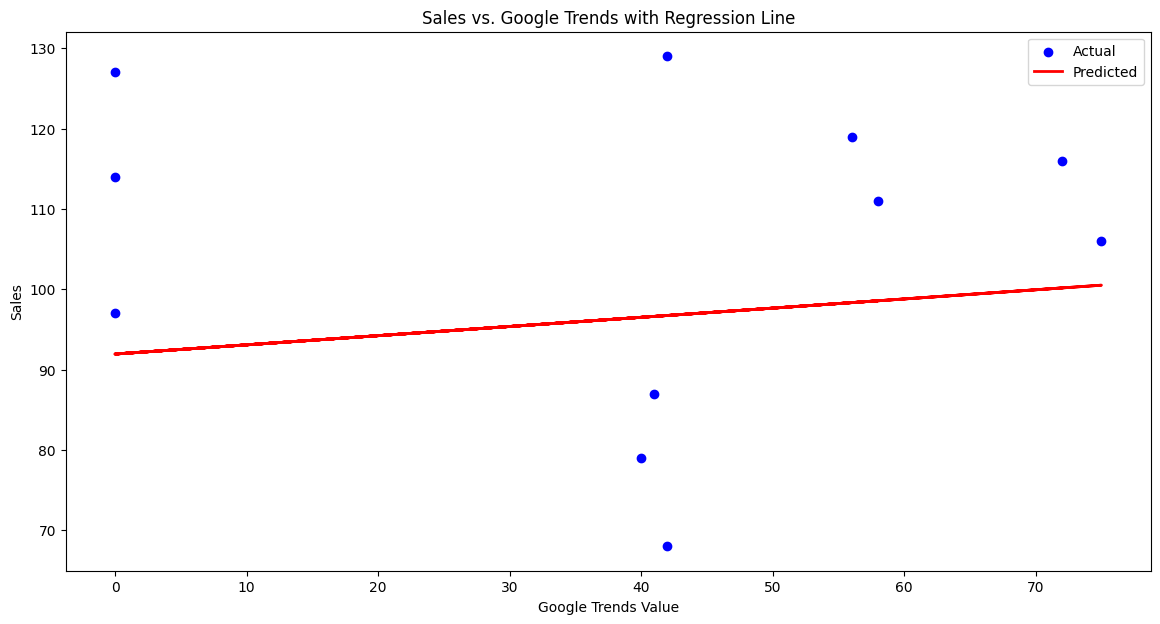

In [100]:
import pytrends
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize pytrends client
pytrends = TrendReq(hl='en-US', tz=360)

# Define the keyword
keyword = 'ready to drink protein shakes'

# Fetch Google Trends data for the specified keyword
def fetch_google_trends_data(keyword):
    pytrends.build_payload(kw_list=[keyword], timeframe='today 5-y')
    interest_over_time_data = pytrends.interest_over_time()
    return interest_over_time_data

google_trends_data = fetch_google_trends_data(keyword)

# Display the fetched data
print(google_trends_data.head())

# Prepare the Google Trends data for regression
# Let's assume we have another dataset with sales data (X) and we want to use trends as an exogenous variable (T)
# For demonstration purposes, let's generate some dummy sales data

# Generate dummy sales data
np.random.seed(0)  # For reproducibility
dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
sales_data = np.random.uniform(low=50, high=150, size=len(dates)).astype(int)
dummy_sales_df = pd.DataFrame({'date': dates, 'sales': sales_data})

# Merge Google Trends data with dummy sales data
merged_data = pd.merge(google_trends_data.reset_index(), dummy_sales_df, left_on='date', right_on='date')

# Drop any rows where the date does not match exactly (though this should be rare)
merged_data.dropna(inplace=True)

# Plot to visualize the relationship between Google Trends and sales data
plt.figure(figsize=(14, 7))
plt.plot(merged_data['date'], merged_data['ready to drink protein shakes'], label='Google Trends')
plt.plot(merged_data['date'], merged_data['sales'], label='Sales Data', alpha=0.5)
plt.title('Google Trends vs Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Prepare the data for regression
X = merged_data[['ready to drink protein shakes']]
y = merged_data['sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
predictions = model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# Perform cross-validation to check for overfitting
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cross_val_mse = -np.mean(scores)
print(f"Cross-Validation Mean Squared Error: {cross_val_mse}")

# Print the coefficients of the model
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Plot the regression line and data points
plt.figure(figsize=(14, 7))
plt.scatter(X_test.values.ravel(), y_test, color='blue', label='Actual')
plt.plot(X_test.values.ravel(), predictions, color='red', linewidth=2, label='Predicted')
plt.title('Sales vs. Google Trends with Regression Line')
plt.xlabel('Google Trends Value')
plt.ylabel('Sales')
plt.legend()
plt.show()